# Operator splitting

In [1]:
include("../smim/smij-functions.jl");

A common trick for solving a difficult time-dependent PDE is to split the equation according to

$$
\partial_t u = A(u) + B(u), 
$$

where $A$ and $B$ might both include spatial derivatives. Often the motivation is that one of the partial operators is linear or easy to handle for some other reason. 

We demonstrate these methods on the *Kuramoto--Sivashinsky equation*, 

$$
\partial_t u = - \partial_x(u^2) - \partial_x^2 u - \partial_x^4 u. 
$$

With periodic conditions, the last term in the PDE has eigenvalues that are $O(N^4)$, making the problem quite stiff. However, we can solve in Fourier space via the splitting

$$
\partial_t \hat{u} = A\hat{u} = (\xi^2 - \xi^4)\hat{u},
$$

which is linear and diagonal, and

$$
\partial_t \hat{u} = B\hat{u} = -i\xi \mathcal{F}[ (\mathcal{F}^{-1}[\hat{u}])^2 ],
$$

which is nonlinear but also nonstiff.

## Integrating factor

Recall that in this case, the splitting is

$$
\partial_t u = Lu + G(u),
$$

where $L$ is linear and responsible for the stiff terms. We multiply this through by $e^{-tL}$ and define the new variable

$$
z = e^{-tL} u,
$$

so that

$$
\partial_t z = e^{-tL} G\bigl( e^{tL}z \bigr). 
$$

This is easy to apply in Fourier space, where $L$ is typically diagonal. Here again is the IF method, applied to the KS equation at second order in time.

In [2]:
N = 140
x, _, _ = trig(N)
x = x .- π
x *= 20/π

m = 1500
Tfin = 100
τ = Tfin/m

u₀ = @. exp(-x^2)

F = plan_rfft(u₀)
F⁻¹ = plan_irfft(F*u₀,N)

ξ = (0:N/2) * π/20
iξ = 1im*[ξ[1:div(N,2)];0]
L = @. ξ^2 - ξ^4
G = û -> -iξ .* (F * (F⁻¹*û).^2 )

#61 (generic function with 1 method)

In [3]:
U = [u₀ zeros(N,m)]
û = F*u₀
E = exp.(τ*L / 2)       # half of the integrating factor   
for n = 1:m
    a = τ*G(û)
    b = τ*G(E .* (û + a/2))
    û = @. E*(E*û + b)
    
    U[:,n+1] = F⁻¹*û       # only needed for plotting
end

using CairoMakie
function animate(name,U)
    index = Observable(1)
    fig = Figure()
    ax = Axis(fig[1,1], xlabel="x", ylabel="u")
    lines!(ax, x, @lift(U[:,$index]))

    record(fig, "$name.mp4", 1:5:m+1) do i
        index[] = i 
        ylims!(ax, -2, 2)
    end
    return nothing
end

animate("if2",U)

<video autoplay width=480 controls><source src="if2.mp4" type="video/mp4"></video>


## Split-step integration

We suppose here that both $A$ and $B$ are autonomous (time-invariant). Consider first

$$
\partial_t u = A(u), \qquad u(t_0,x) = u_0(x). 
$$

Without worrying about it too much, let's define the exponential of the operator $A$ via propagation of the initial condition in this problem:

$$
e^{(t-t_0)A} u_0 = u(t). 
$$

We can do the same for $B$. The simplest **split-step solver** of the original PDE is then

$$
u(t+\tau) = e^{\tau B} e^{\tau A} u(t). 
$$

If the subproblems are solved exactly, then this method is $O(\tau)$, i.e., first order. The more symmetric **Strang splitting** 

$$
u(t+\tau) = \exp( \tfrac{1}{2} \tau A) \exp( \tau B) \exp( \tfrac{1}{2} \tau A) u(t)
$$

is second-order in time. It's normally used by combining the half-step operators in consecutive steps, i.e., 

$$
u(t+n\tau) = \exp( \tfrac{1}{2} \tau A) \exp( \tau B) \exp( \tau A)  \exp( \tau B)  \cdots  \exp( \tau B)\exp( \tfrac{1}{2} \tau A)  u(t), 
$$

which is more efficient but does not allow knowing the solution accurately at any time between the start and the end.

We demonstrate split-step on the KS equation by pairing exact advancement of $e^A$ with a 2nd-order RK method for approximating $e^B$.

In [4]:
expA = û -> exp.(τ*L) .* û
expA2 = û -> exp.(0.5τ*L) .* û

function expB(û)
    s₁ = τ*G(û)
    return û + τ*G(û + s₁/2)
end;

In order to make the animation easily, we are not merging the half-steps on the $A$ operator here:

In [5]:
û = F*u₀
U = [u₀ zeros(N,m)]
for n in 1:m
    û = expA2( expB( expA2(û) ) )
    U[:,n+1] = F⁻¹*û    
end;

animate("splitstep",U)

<video autoplay width=480 controls><source src="splitstep.mp4" type="video/mp4"></video>

Thanks to the *Baker--Campbell--Hausdorff formula*, there exist split-step methods of any even order. They aren't often used, though, because they require longer sequences of substeps to advance one full time step, and some of the substep increments are necessarily negative, raising issues with stability (e.g., backward diffusion).

## IMEX methods

In the event of a linear/nonlinear splitting in the form

$$
\partial_t u = Lu + G(u), 
$$

a simple idea is to use a hybrid **IMEX** formula for time-stepping. If the linear part is responsible for the stiffness, then we can simultaneously use an implicit method on the linear part and an explicit one on the nonlinear term. For example, we could combine AM2 (Trapezoid) with AB2 via

$$
u_{n+1} = u_n + \tfrac{1}{2} \tau\bigl[ Lu_{n+1} + Lu_n + 3G(u_n) - G(u_{n-1})  \bigr]. 
$$

Thus, there is only a linear problem to solve for $u_{n+1}$. We can investigate the absolute stability of this method via the assumptions $Lu=\lambda u$, $G(u)=\mu u$, and $u_k=z^k$, which leads to

$$
\left(1-\tfrac{1}{2} \tau \lambda\right) z = 1 + \tfrac{1}{2} (\tau\lambda) + \tfrac{3}{2} (\tau \mu) - \tfrac{1}{2}(\tau \mu) z^{-1}. 
$$

For the KS equation, we could set $\lambda \tau = \alpha$ for $\alpha<0$ and $\mu\tau= i\beta$:

$$
(2-\alpha)z^2 - (2 +\alpha + 3i\beta)z + i\beta = 0. 
$$

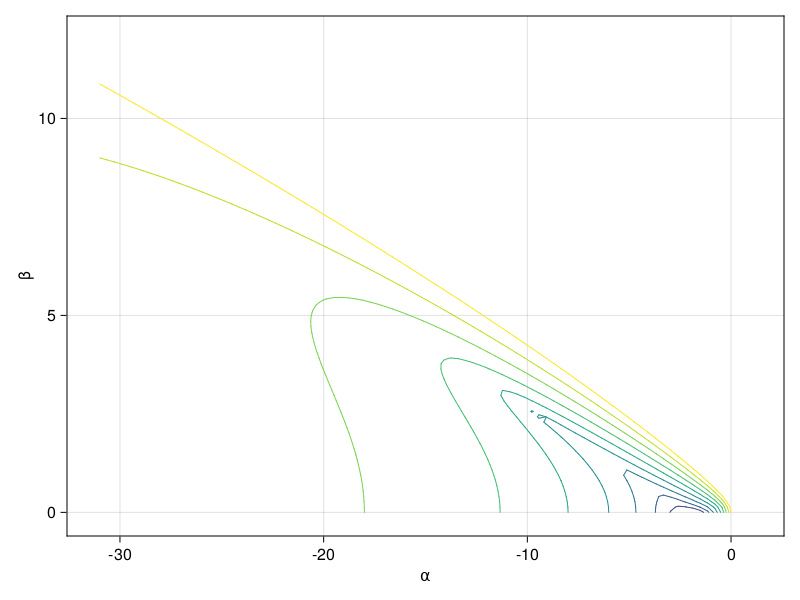

In [6]:
using Polynomials
⍺ = range(-31,1,90)
β = range(0,12,90)
zpoly(⍺,β) = Polynomial([1im*β, -2-⍺+3im*β, 2-⍺])
R = [ maximum( abs, roots(zpoly(x,y))) for x in ⍺, y in β ]
contour(⍺, β, R, levels=0.2:0.1:1, 
    colorrange=(0.,1.), axis=(xlabel="⍺", ylabel="β"))

As you can see from the yellow curve above, it appears that we can maintain stability if $|\beta| < |\alpha|/4$. For the KS equation we might expect $|\alpha/\beta| = O(N^3)$, so this should not be an issue.

In [7]:
U = [u₀ zeros(N,m)]
û = F*u₀

# one step of BE/Euler to get starting value
G_old = G(û)
û = @. (û + τ*G_old) / (1 - τ*L)
U[:,2] = F⁻¹*û

# TR/AB method
for i in 2:m
    Gu = G(û)
    @. û = ( û + 0.5τ*(L*û + 3Gu - G_old) ) / (1 - 0.5τ*L)
    G_old = Gu
    U[:,i+1] .= F⁻¹*û
end

animate("imex",U)

<video autoplay width=480 controls><source src="imex.mp4" type="video/mp4"></video>

## Exponential time differencing

If we integrate the IF equation over a time step, we get


$$
z(\tau) = z(0) + \int_0^\tau e^{-tL} G\bigl( e^{tL}z \bigr)\, dt. 
$$

Returning to the original variable, we get

$$
u(\tau) = e^{\tau L}u(0) + e^{\tau L} \int_0^\tau e^{-tL} G(u(t)) \, dt.
$$

If we apply, say, a traditional Adams method to solve this equation, we would replace the integrand by a polynomial interpolating it at $0, -\tau,\ldots.$ However, we might do better approximating the integral via a specialized formula,

$$
\int_0^\tau e^{-tL} P(t) \, dt,
$$

where $P$ interpolates *only $G$ values* at the previous time steps. For example, if we use a linear interpolant through $G_0$ and $G_{-1}$, we get

$$
\int_0^\tau e^{-tL} P(t) \, dt & = \int_0^\tau \frac{e^{-tL}}{\tau} [-t G_{-1} + (\tau + t)G_0 ] \, dt \\ 
&= L^{-1}(I-e^{-\tau L}) G_0 + L^{-2} \left[ I - (I+\tau L)e^{-\tau L} \right] (G_0-G_{-1}),
$$

where we have used notation that allows $L$ and $G$ to be operators as well as scalars. Hence, a 2nd order method is

$$
u(\tau) = e^{\tau L}u(0) + L^{-1}(e^{\tau L}-I) G_0 + L^{-2} \left[ e^{\tau L} - I - \tau L \right] (G_0-G_{-1}). 
$$

This type of method is known as **exponential time differencing** (ETD). There are corresponding formulas based on RK methods, but they are not as easy to describe or derive.

Clearly, we need the ability to evaluate $e^{\tau L}v$; i.e., to advance the linear part of the PDE one time step. In the KS example, this operator is diagonal in Fourier space, so there is no difficulty, but in other cases, more advanced techniques (e.g., Krylov subspaces) may be used. 

More subtly, the method needs a careful implementation to avoid numerical instability. In scalar form, the above formulas are

$$
u(\tau) = e^{\tau \lambda}u(0) + \frac{e^{\tau \lambda}-1}{\lambda} g_0 + \frac{e^{\tau \lambda} - 1 - \tau \lambda}{\lambda^2}(g_0-g_{-1}), 
$$

and it's clear that we will be up against subtractive cancellation. Cox and Matthews, who first published these methods, suggested using series expansions for small $\lambda$, which requires diagonalization. However, Kassam and Trefethen showed that one can use contour integrals

$$
f(L) = \frac{1}{2\pi i}\oint_C f(t)(tI-L)^{-1}\, dt,
$$

as approximated by (wait for it) the trapezoid formula on a closed contour enclosing the eigenvalues.

In [8]:
f₁ = z -> (exp(z) - 1) / z
f₂ = z -> (exp(z) - 1 - z) / z^2
a = zeros(length(L),2)
M = 200
circ = @. cis(2π*(1:M)/M)
for (i,p) in enumerate(τ*L)
    R = max(0.1,abs(0.1*p))  # radius of contour
    z = @. p + R*circ        # points on contour
    dz = @. 1im*R*circ       # dz/dθ
    
    a[i,1] = τ/M * imag(sum(f₁(z)/(z-p)*dz for (z,dz) in zip(z,dz)))
    a[i,2] = τ^2/M * imag(sum(f₂(z)/(z-p)*dz for (z,dz) in zip(z,dz)))
end

U = [u₀ zeros(N,m)]
û = F*u₀

# one step of BE/Euler to get starting value
G₀ = G(û)
û = @. (û + τ*G₀) / (1 - τ*L)
U[:,2] = F⁻¹*û

E = exp.(τ*L)
for i in 2:m
    G₋₁,G₀ = G₀,G(û)
    û = E.*û + a[:,1].*G₀ + a[:,2].*(G₀-G₋₁)
    U[:,i+1] = F⁻¹*û
end

animate("etd",U)

<video autoplay width=480 controls><source src="etd.mp4" type="video/mp4"></video>